In [13]:
import importlib

In [14]:
import Data_Prep
importlib.reload(Data_Prep)
from Data_Prep import Data_Prep

data_prep = Data_Prep()

In [15]:
pitchers, inputs, outputs, max_input_size, dates = data_prep.Generate_IO_Pitchers("WHERE (lastProspectYear<? OR lastMLBSeason<?) AND isPitcher=?", (2025,2025,1))

In [16]:
from sklearn.model_selection import train_test_split # type: ignore
import torch
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=4980)

train_lengths = torch.tensor([len(seq) for seq in x_train])
test_lengths = torch.tensor([len(seq) for seq in x_test])

x_train_padded = torch.nn.utils.rnn.pad_sequence(x_train)
x_test_padded = torch.nn.utils.rnn.pad_sequence(x_test)
y_train_padded = torch.nn.utils.rnn.pad_sequence(y_train)
y_test_padded = torch.nn.utils.rnn.pad_sequence(y_test)

In [17]:
import Pitcher_Dataset
importlib.reload(Pitcher_Dataset)
from Pitcher_Dataset import Pitcher_Dataset

train_pitchers_dataset = Pitcher_Dataset(x_train_padded, train_lengths, y_train_padded)
test_pitchers_dataset = Pitcher_Dataset(x_test_padded, test_lengths, y_test_padded)

Train Model

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Generating Pitcher Mutators:   0%|          | 0/1000 [00:00<?, ?it/s]

Num. Parameters: 8448
Epoch [1/1000], Train Loss: 1.6576, Test Loss: 1.4069
Epoch [2/1000], Train Loss: 1.0155, Test Loss: 0.6089
Epoch [3/1000], Train Loss: 0.5002, Test Loss: 0.4525
Epoch [4/1000], Train Loss: 0.4638, Test Loss: 0.4623
Epoch [5/1000], Train Loss: 0.4493, Test Loss: 0.4382
Epoch [6/1000], Train Loss: 0.4272, Test Loss: 0.4317
Epoch [7/1000], Train Loss: 0.4248, Test Loss: 0.4318
Epoch [8/1000], Train Loss: 0.4257, Test Loss: 0.4304
Epoch [9/1000], Train Loss: 0.4244, Test Loss: 0.4305
Epoch [10/1000], Train Loss: 0.4238, Test Loss: 0.4304
Epoch [11/1000], Train Loss: 0.4263, Test Loss: 0.4305
Epoch [12/1000], Train Loss: 0.4266, Test Loss: 0.4306
Epoch [13/1000], Train Loss: 0.4248, Test Loss: 0.4305
Epoch [14/1000], Train Loss: 0.4275, Test Loss: 0.4306
Epoch [15/1000], Train Loss: 0.4272, Test Loss: 0.4306
Epoch [16/1000], Train Loss: 0.4293, Test Loss: 0.4307
Epoch [17/1000], Train Loss: 0.4267, Test Loss: 0.4311
Epoch [18/1000], Train Loss: 0.4309, Test Loss: 0.43

0.28006914258003235

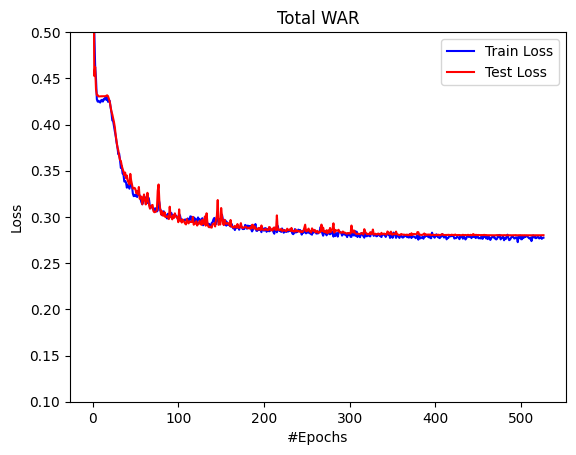

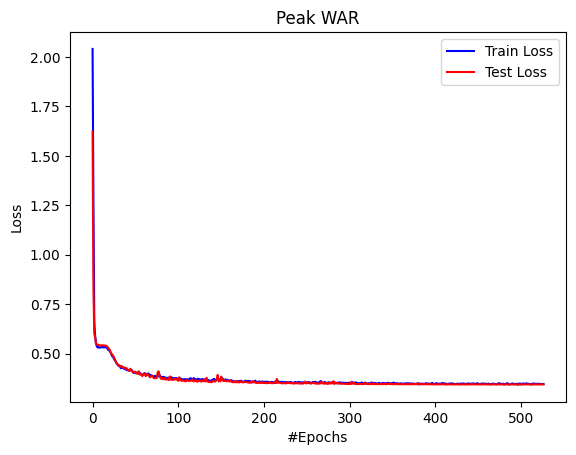

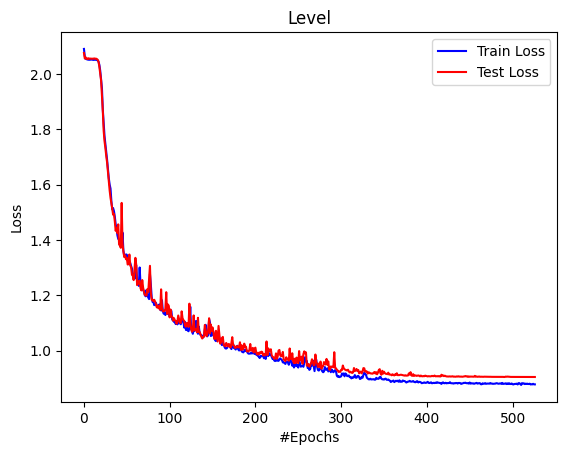

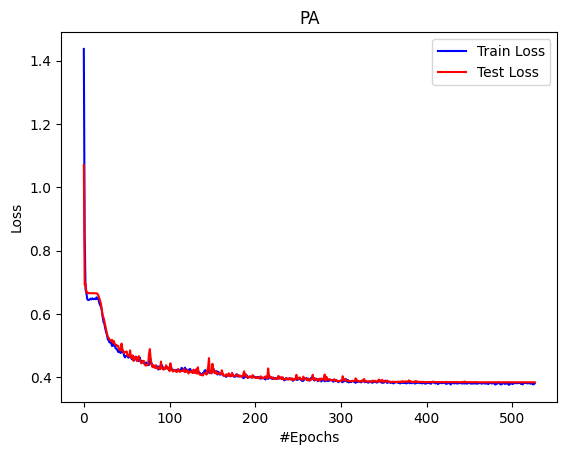

In [23]:
import Pitcher_Model
importlib.reload(Pitcher_Model)
from Pitcher_Model import RNN_Model, Classification_Loss
from torch.optim import lr_scheduler
import Model_Train
importlib.reload(Model_Train)
from Model_Train import trainAndGraph
from Constants import device

batch_size = 1000
pitching_mutators = data_prep.Generate_Pitching_Mutators(batch_size, max_input_size)

num_layers = 3
hidden_size = 30
network = RNN_Model(x_train_padded[0].shape[1], num_layers, hidden_size, pitching_mutators)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

optimizer = torch.optim.Adam(network.parameters(), lr=0.003)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=20, cooldown=5, verbose=False)
loss_function = Classification_Loss

num_epochs = 1000
training_generator = torch.utils.data.DataLoader(train_pitchers_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_pitchers_dataset, batch_size=batch_size, shuffle=False)

graph_y_range=(0.1,0.5)
trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, scheduler, num_epochs, logging_interval=1, early_stopping_cutoff=40, should_output=True, graph_y_range=graph_y_range)

Testing

In [20]:
network.load_state_dict(torch.load("no_name.pt"))
network.eval()
network = network.to(device)

In [21]:
import torch.nn.functional as F

def Check_Pitcher(id : int, name : str):
    with torch.no_grad():
        for i, pitcher in enumerate(pitchers):
            if (pitcher.mlbId == id):
                input = inputs[i].unsqueeze(0)
                
                output = outputs[i]
                l = torch.tensor([input.shape[1]])
                twar, pwar, level, pa = network(input.to(device), l.to(device))
                
                torch.set_printoptions(precision=3, sci_mode=False, linewidth=1000)
                print(name)
                print(F.softmax(twar.squeeze(0).squeeze(1), dim=1).cpu())
                #print(F.softmax(level.squeeze(0).squeeze(1), dim=1).cpu())
                print(output[0][0].item())
                #print(output[0][2].item())
                return

Get Hitter Losses

In [22]:
#Check_Pitcher(621244, "Jose Berrios")
Check_Pitcher(592102, "Cody Allen")

Cody Allen
tensor([[    0.904,     0.039,     0.035,     0.014,     0.007,     0.001,     0.000],
        [    0.909,     0.037,     0.033,     0.013,     0.007,     0.001,     0.000],
        [    0.909,     0.037,     0.033,     0.013,     0.007,     0.001,     0.000],
        [    0.909,     0.037,     0.033,     0.013,     0.007,     0.001,     0.000],
        [    0.909,     0.037,     0.033,     0.013,     0.007,     0.001,     0.000],
        [    0.909,     0.037,     0.033,     0.013,     0.007,     0.001,     0.000],
        [    0.909,     0.037,     0.033,     0.013,     0.007,     0.001,     0.000],
        [    0.909,     0.037,     0.033,     0.013,     0.007,     0.001,     0.000],
        [    0.909,     0.037,     0.033,     0.013,     0.007,     0.001,     0.000],
        [    0.909,     0.037,     0.033,     0.013,     0.007,     0.001,     0.000],
        [    0.909,     0.037,     0.033,     0.013,     0.007,     0.001,     0.000],
        [    0.909,     0.037,  